In [14]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import nltk
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm
import multiprocessing as mp

# Load the data

In [2]:
episodes_df = pd.read_pickle("episode_dict.pickle")
episodes_df

,pokemon,plot
001,"[Kakuna, Chansey, Mankey, Bellsprout, Pikachu,...","In Pallet Town, a young Ash Ketchum is beside ..."
002,"[Kakuna, Pidgeotto, Bisharp, Blastoise, Mankey...",Ash is attending the opening of Professor Ceri...
003,"[Pikachu, Yamper, Oddish, Meowth, Poliwag, Pel...",Ash and Goh are embarking on their first full ...
004,"[Zweilous, Turtwig, Nickit, Pikachu, Sneasel, ...",Ash and Goh head to the Galar region to see a ...
005,"[Goomy, Braviary, Seedot, Grubbin, Munchlax, P...",It’s time for research fellows Ash and Goh to ...
...,...,...
132,"[Pidgeotto, Boldore, Oshawott, Gible, Pikachu,...",Eternatus has appeared above Wyndon Stadium du...
133,"[Virizion, Solrock, Totodile, Pikachu, Yanma, ...",While Ash and Leon's battle in the Masters Eig...
134,"[Virizion, Blastoise, Tirtouga, Pikachu, Ratta...","The Chasers of Project Mew, having gotten spli..."
135,"[Boldore, Oshawott, Gible, Arctozolt, Zacian, ...",Following Ash's victory against Leon in the fi...


# Create the graph and the pokemon communities

In [3]:
with open("anime_graph.pickle", "rb") as f:
    anime_graph = pickle.load(f)

nodes = anime_graph.nodes(data=True)

pokemon_communities_df = pd.DataFrame([[pokemon, data["group"]] for pokemon, data in nodes], columns=["pokemon", "community"])
pokemon_communities_df

,pokemon,community
0,Kakuna,2
1,Chansey,1
2,Mankey,2
3,Bellsprout,2
4,Pikachu,4
...,...,...
672,Bastiodon,4
673,Seel,1
674,Cherrim,1
675,Cubchoo,1


## Counts per community

In [4]:
community_counts = pokemon_communities_df["community"].value_counts()

## Create the tokenizer

In [5]:
from typing import Optional


def tokenizer(text: str, stopwords: set[str], lemmatizer: Optional[nltk.WordNetLemmatizer] = None) -> str:
    word_tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in word_tokens if word.isalpha() and word.lower() not in stopwords]

    if lemmatizer is not None:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [6]:
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.WordNetLemmatizer()

episodes_df["tokens"] = episodes_df["plot"].apply(lambda text: tokenizer(text, stopwords, lemmatizer))

episodes_df.head()

,pokemon,plot,tokens
001,"[Kakuna, Chansey, Mankey, Bellsprout, Pikachu,...","In Pallet Town, a young Ash Ketchum is beside ...","[pallet, town, young, ash, ketchum, beside, go..."
002,"[Kakuna, Pidgeotto, Bisharp, Blastoise, Mankey...",Ash is attending the opening of Professor Ceri...,"[ash, attending, opening, professor, cerise, n..."
003,"[Pikachu, Yamper, Oddish, Meowth, Poliwag, Pel...",Ash and Goh are embarking on their first full ...,"[ash, goh, embarking, first, full, day, resear..."
004,"[Zweilous, Turtwig, Nickit, Pikachu, Sneasel, ...",Ash and Goh head to the Galar region to see a ...,"[ash, goh, head, galar, region, see, phenomeno..."
005,"[Goomy, Braviary, Seedot, Grubbin, Munchlax, P...",It’s time for research fellows Ash and Goh to ...,"[time, research, fellow, ash, goh, explore, ga..."


In [7]:
all_tokens = episodes_df["tokens"].sum()

fdist = nltk.FreqDist(all_tokens)
most_common = fdist.most_common(50)

for word, freq in most_common:
    print("{}: {}".format(word, freq))

ash: 2526
goh: 2379
pokémon: 1235
pikachu: 727
chloe: 581
battle: 502
attack: 457
team: 446
back: 412
rocket: 391
cerise: 356
however: 344
one: 331
leon: 323
use: 308
start: 301
professor: 296
time: 290
catch: 281
get: 279
find: 270
call: 270
try: 266
lucario: 257
first: 249
ball: 241
take: 234
make: 233
move: 232
tell: 231
also: 231
gengar: 231
two: 220
see: 219
next: 217
trainer: 209
eevee: 207
suddenly: 203
away: 203
us: 190
dragonite: 189
scorbunny: 188
order: 186
help: 186
another: 182
jessie: 181
come: 179
go: 178
hit: 174
still: 173


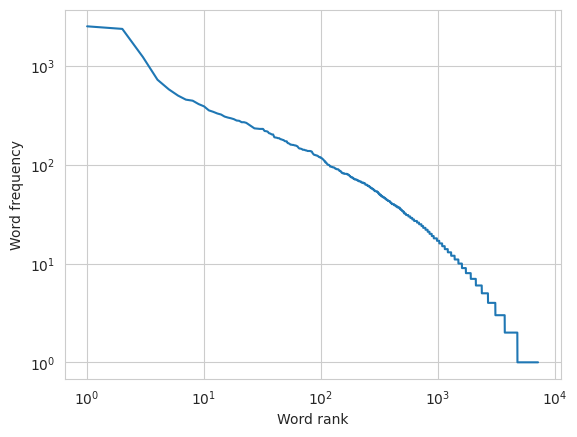

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_zipf(tokens):
    fdist = nltk.FreqDist(tokens)
    most_common = fdist.most_common()

    x = np.arange(1, len(most_common) + 1)
    y = [freq for word, freq in most_common]

    plt.plot(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Word rank")
    plt.ylabel("Word frequency")
    plt.show()

plot_zipf(all_tokens)

In [11]:
def get_bigrams(tokens):
    return list(nltk.bigrams(tokens))

episodes_df["bigrams"] = [get_bigrams(tokens) for tokens in episodes_df["tokens"]]

all_bigrams = [bigram for bigrams in episodes_df["bigrams"] for bigram in bigrams]

In [29]:
from collections import Counter
from joblib import parallel_backend, Parallel, delayed

unique_bigrams = set(all_bigrams)
print("Unique bigrams:", len(unique_bigrams))
print("All bigrams:", len(all_bigrams))
print("Unique words:", len(set(all_tokens)))

def contingency_table(bigram, all_bigrams_count, unique_words):
    n_ii = all_bigrams_count[bigram]

    n_io = 0
    n_oi = 0

    for other in unique_words:
        if other != bigram[1]:
            n_io += all_bigrams_count[(bigram[0], other)]
        if other != bigram[0]:
            n_oi += all_bigrams_count[(other, bigram[1])]

    n_oo = len(all_bigrams) - n_ii - n_io - n_oi
    return np.array([[n_ii, n_io], [n_oi, n_oo]])

all_bigrams_count = Counter(all_bigrams)

contingency_tables = Parallel(n_jobs=-1, prefer="threads")(delayed(contingency_table)(bigram, all_bigrams_count, set(all_tokens)) for bigram in tqdm(unique_bigrams))
contingency_tables[0]

Unique bigrams: 63241
All bigrams: 84337
Unique words: 7208


  0%|          | 0/63241 [00:00<?, ?it/s]

array([[    1,    68],
       [  157, 84111]])

In [33]:
## Calculate P-values
chi2_contingencies = Parallel(n_jobs=-1, prefer="threads")(delayed(stats.chi2_contingency)(table) for table in tqdm(contingency_tables))

p_values = [p for _, p, _, _ in chi2_contingencies]

  0%|          | 0/63241 [00:00<?, ?it/s]

In [40]:
bigrams_df = pd.DataFrame({"bigram": list(unique_bigrams), "p_value": p_values})
bigrams_df.sort_values("p_value", inplace=True, ascending=True)

In [41]:
bigrams_df

,bigram,p_value
20557,"(electronic, device)",0.0
29420,"(difference, loser)",0.0
34084,"(today, abysmal)",0.0
20141,"(helpless, marshtomp)",0.0
36610,"(rocket, trio)",0.0
...,...,...
8151,"(steven, ash)",1.0
8147,"(gengar, take)",1.0
61414,"(ash, pair)",1.0
20770,"(gengar, leon)",1.0


In [42]:
bigrams_df[bigrams_df["p_value"] < 0.001].head(10)

,bigram,p_value
20557,"(electronic, device)",0.0
29420,"(difference, loser)",0.0
34084,"(today, abysmal)",0.0
20141,"(helpless, marshtomp)",0.0
36610,"(rocket, trio)",0.0
16058,"(consult, dex)",0.0
16060,"(dragon, breath)",0.0
61750,"(herbal, medicine)",0.0
37644,"(fleet, worn)",0.0
55980,"(showdown, signaled)",0.0


In [43]:
bigrams_df[bigrams_df["p_value"] < 0.001].count()

bigram     38272
p_value    38272
dtype: int64

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tokenizer(stopwords, lemmatizer):
    def tokenizer(text):
        word_tokens = nltk.word_tokenize(text)
        tokens = [word.lower() for word in word_tokens if word.isalpha() and word.lower() not in stopwords]

        if lemmatizer is not None:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens

    return tokenizer

tfidf = TfidfVectorizer(tokenizer=get_tokenizer(stopwords, lemmatizer), ngram_range=(1, 2), strip_accents="ascii")

tfidf_matrix = tfidf.fit_transform(episodes_df["plot"])

In [50]:
tfidf.get_feature_names_out()

array(['aback', 'aback ash', 'aback dust', ..., 'zoroark attack',
       'zoroark happily', 'zoroark pin'], dtype=object)

In [51]:
# Group by community and get the concatenated token lists

combined_df = episodes_df.explode("pokemon").merge(pokemon_communities_df, on="pokemon")
combined_df.head()

,pokemon,plot,tokens,bigrams,community
0,Kakuna,"In Pallet Town, a young Ash Ketchum is beside ...","[pallet, town, young, ash, ketchum, beside, go...","[(pallet, town), (town, young), (young, ash), ...",2
1,Kakuna,Ash is attending the opening of Professor Ceri...,"[ash, attending, opening, professor, cerise, n...","[(ash, attending), (attending, opening), (open...",2
2,Kakuna,After catching Scorbunny and learning about hi...,"[catching, scorbunny, learning, pokédex, goh, ...","[(catching, scorbunny), (scorbunny, learning),...",2
3,Kakuna,Ash and Goh are off to the Hoenn region to com...,"[ash, goh, hoenn, region, compete, battle, fro...","[(ash, goh), (goh, hoenn), (hoenn, region), (r...",2
4,Kakuna,Ash and Goh head to Ecruteak City in Johto to ...,"[ash, goh, head, ecruteak, city, johto, invest...","[(ash, goh), (goh, head), (head, ecruteak), (e...",2


In [54]:
grouped_df = combined_df.groupby("community")["tokens"].apply(lambda tokens: [token for token_list in tokens for token in token_list])
community_tokens_dict = grouped_df.to_dict()
display(community_tokens_dict)
display(grouped_df)

{0: ['ash',
  'goh',
  'checking',
  'tentacool',
  'pokémon',
  'race',
  'toward',
  'across',
  'exhausted',
  'ravenous',
  'piplup',
  'learn',
  'trainer',
  'lauren',
  'searching',
  'swam',
  'away',
  'sinnoh',
  'region',
  'turn',
  'proud',
  'piplup',
  'engaged',
  'fierce',
  'rivalry',
  'lauren',
  'pokémon',
  'croagunk',
  'love',
  'spoiled',
  'back',
  'sinnoh',
  'piplup',
  'challenge',
  'croagunk',
  'pokémon',
  'iceberg',
  'race',
  'team',
  'rocket',
  'throw',
  'event',
  'chaos',
  'lauren',
  'find',
  'danger',
  'two',
  'pokémon',
  'set',
  'aside',
  'difference',
  'save',
  'become',
  'good',
  'friend',
  'result',
  'ash',
  'goh',
  'come',
  'across',
  'large',
  'school',
  'tentacool',
  'coast',
  'vermilion',
  'city',
  'ash',
  'particularly',
  'excited',
  'poke',
  'one',
  'find',
  'tentacool',
  'soft',
  'squishy',
  'response',
  'tentacool',
  'lash',
  'ash',
  'bubble',
  'beam',
  'face',
  'goh',
  'decides',
  'add',


community
0    [ash, goh, checking, tentacool, pokémon, race,...
1    [pallet, town, young, ash, ketchum, beside, go...
2    [pallet, town, young, ash, ketchum, beside, go...
3    [pallet, town, young, ash, ketchum, beside, go...
4    [pallet, town, young, ash, ketchum, beside, go...
Name: tokens, dtype: object

Community: 0
Tokens: 21035
Unique tokens: 2199

TF:
ash: 816.0
goh: 798.0
mewtwo: 600.0
pokemon: 557.0
pikachu: 265.0

IDF:
ash: 4.248351439849232
goh: 4.27062958894296
mewtwo: 4.555395600174027
pokemon: 4.6296315723279235
pikachu: 5.370494225927536



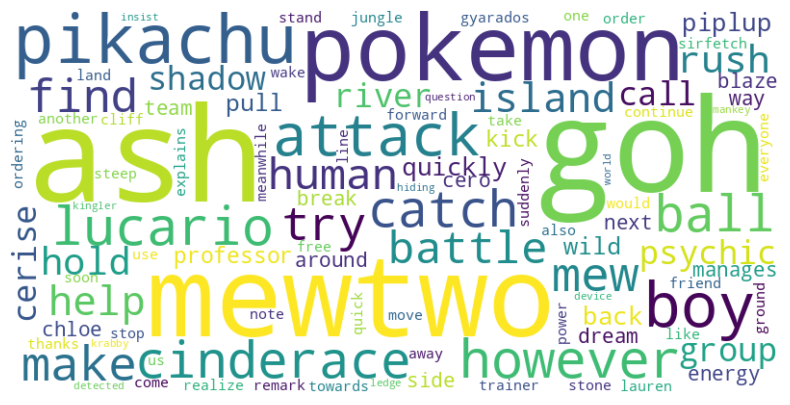

Community: 1
Tokens: 296748
Unique tokens: 6354

TF:
goh: 9316.0
ash: 9305.0
pokemon: 5985.0
pikachu: 3077.0
chloe: 2997.0

IDF:
goh: 4.461045975175879
ash: 4.46222731022171
pokemon: 4.90346325421366
pikachu: 5.56860662822748
chloe: 5.594941263963761



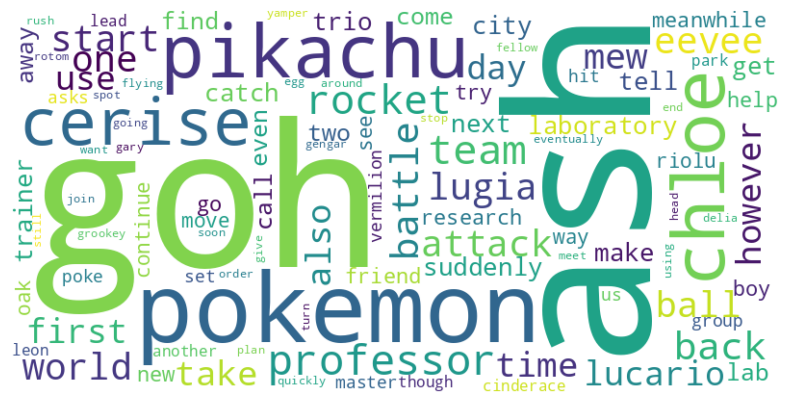

Community: 2
Tokens: 882135
Unique tokens: 7003

TF:
goh: 31268.0
ash: 25924.0
pokemon: 15966.0
pikachu: 10084.0
team: 6722.0

IDF:
goh: 4.339719047706005
ash: 4.527138485015709
pokemon: 5.011822146773736
pikachu: 5.471297067725125
team: 5.8768117556444



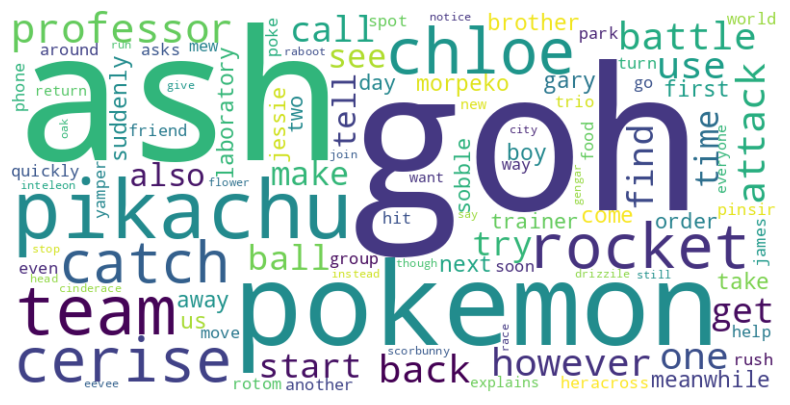

Community: 3
Tokens: 830494
Unique tokens: 7208

TF:
ash: 28327.0
goh: 16692.0
pokemon: 14283.0
pikachu: 8022.0
battle: 7126.0

IDF:
ash: 4.378171193756027
goh: 4.907032438692379
pokemon: 5.062881878833428
pikachu: 5.639709491794111
battle: 5.758131520045896



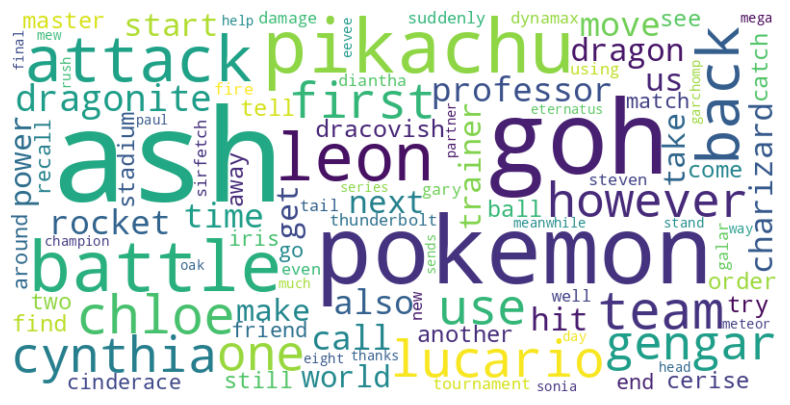

Community: 4
Tokens: 619808
Unique tokens: 7208

TF:
goh: 18908.0
ash: 17098.0
pokemon: 9679.0
chloe: 5625.0
pikachu: 4873.0

IDF:
goh: 4.4897733668623045
ash: 4.590391383794932
pokemon: 5.159349464772902
chloe: 5.702012655993722
pikachu: 5.845496410858373



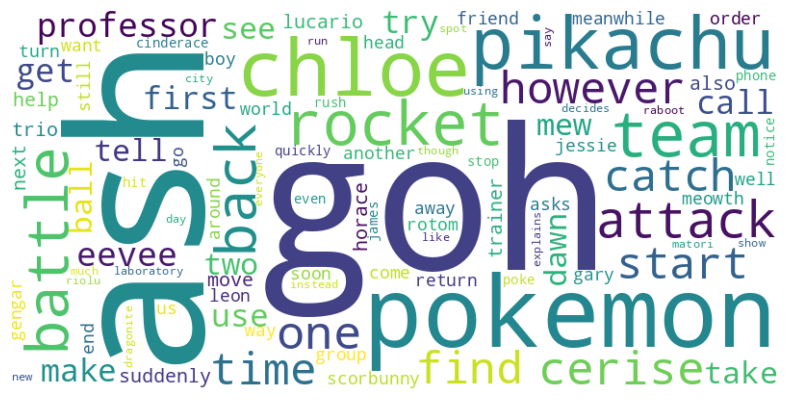

In [65]:
from wordcloud import WordCloud
communities = list(community_tokens_dict.keys())
for community in communities:
    print("Community:", community)
    print("Tokens:", len(community_tokens_dict[community]))
    print("Unique tokens:", len(set(community_tokens_dict[community])))
    print()

    tfidf = TfidfVectorizer(ngram_range=(1, 1), strip_accents="ascii")
    tfidf_matrix = tfidf.fit_transform(community_tokens_dict[community])

    # print top 10 n grams
    print("TF:")
    feature_names = tfidf.get_feature_names_out()
    episode_scores = tfidf_matrix.sum(axis=0)
    episode_scores = np.squeeze(np.asarray(episode_scores))
    sorted_ngrams = sorted(zip(episode_scores, feature_names), reverse=True)
    for score, ngram in sorted_ngrams[:5]:
        print(f"{ngram}: {score}")

    print()
    print("IDF:")
    # print top 10 idf scores
    idf_scores = tfidf.idf_
    sorted_idf_scores = sorted(zip(idf_scores, feature_names))
    for score, ngram in sorted_idf_scores[:5]:
        print(f"{ngram}: {score}")
    print()

    wordcloud = WordCloud(background_color="white", max_words=100, width=800, height=400).generate_from_frequencies(dict(zip(feature_names, episode_scores)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()